<a href="https://colab.research.google.com/github/HerbertMariano/time-series-forecasting/blob/main/mancha_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install itables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

In [5]:
df.sort_values('Month',inplace=True)
df.set_index('Month',inplace=True)

In [6]:
features = ['Sunspots']
target = []

In [7]:
df

Sunspots
Month            
1749-01      58.0
1749-02      62.6
1749-03      70.0
1749-04      55.7
1749-05      85.0
...           ...
1983-08      71.8
1983-09      50.3
1983-10      55.8
1983-11      33.3
1983-12      33.4

[2820 rows x 1 columns]

In [8]:
for i in range(1,12):
    df[f'm{-i}'] = df['Sunspots'].shift(i)
    features.append(f'm{-i}')
    
df[f'm+1'] = df['Sunspots'].shift(-1)
df[f'm+2'] = df['Sunspots'].shift(-2)
target = ['m+1','m+2']

In [9]:
df.head(20)

Sunspots    m-1    m-2    m-3    m-4    m-5    m-6    m-7    m-8  \
Month                                                                       
1749-01      58.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1749-02      62.6   58.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1749-03      70.0   62.6   58.0    NaN    NaN    NaN    NaN    NaN    NaN   
1749-04      55.7   70.0   62.6   58.0    NaN    NaN    NaN    NaN    NaN   
1749-05      85.0   55.7   70.0   62.6   58.0    NaN    NaN    NaN    NaN   
1749-06      83.5   85.0   55.7   70.0   62.6   58.0    NaN    NaN    NaN   
1749-07      94.8   83.5   85.0   55.7   70.0   62.6   58.0    NaN    NaN   
1749-08      66.3   94.8   83.5   85.0   55.7   70.0   62.6   58.0    NaN   
1749-09      75.9   66.3   94.8   83.5   85.0   55.7   70.0   62.6   58.0   
1749-10      75.5   75.9   66.3   94.8   83.5   85.0   55.7   70.0   62.6   
1749-11     158.6   75.5   75.9   66.3   94.8   83.5   85.0   55.7   70.0   
1749-12      85.2  158.6   75.5   75.9   66.3   94.8   83.5   85.0   55.7   
1750-01      73.3   85.2  158.6   75.5   75.9   66.3   94.8   83.5   85.0   
1750-02      75.9   73.3   85.2  158.6   75.5   75.9   66.3   94.8   83.5   
1750-03      89.2   75.9   73.3   85.2  158.6   75.5   75.9   66.3   94.8   
1750-04      88.3   89.2   75.9   73.3   85.2  158.6   75.5   75.9   66.3   
1750-05      90.0   88.3   89.2   75.9   73.3   85.2  158.6   75.5   75.9   
1750-06     100.0   90.0   88.3   89.2   75.9   73.3   85.2  158.6   75.5   
1750-07      85.4  100.0   90.0   88.3   89.2   75.9   73.3   85.2  158.6   
1750-08     103.0   85.4  100.0   90.0   88.3   89.2   75.9   73.3   85.2   

           m-9  m-10  m-11    m+1    m+2  
Month                                     
1749-01    NaN   NaN   NaN   62.6   70.0  
1749-02    NaN   NaN   NaN   70.0   55.7  
1749-03    NaN   NaN   NaN   55.7   85.0  
1749-04    NaN   NaN   NaN   85.0   83.5  
1749-05    NaN   NaN   NaN   83.5   94.8  
1749-06    NaN   NaN   NaN   94.8   66.3  
1749-07    NaN   NaN   NaN   66.3   75.9  
1749-08    NaN   NaN   NaN   75.9   75.5  
1749-09    NaN   NaN   NaN   75.5  158.6  
1749-10   58.0   NaN   NaN  158.6   85.2  
1749-11   62.6  58.0   NaN   85.2   73.3  
1749-12   70.0  62.6  58.0   73.3   75.9  
1750-01   55.7  70.0  62.6   75.9   89.2  
1750-02   85.0  55.7  70.0   89.2   88.3  
1750-03   83.5  85.0  55.7   88.3   90.0  
1750-04   94.8  83.5  85.0   90.0  100.0  
1750-05   66.3  94.8  83.5  100.0   85.4  
1750-06   75.9  66.3  94.8   85.4  103.0  
1750-07   75.5  75.9  66.3  103.0   91.2  
1750-08  158.6  75.5  75.9   91.2   65.7

In [10]:
df.dropna(inplace=True)

In [11]:
test = df[df.index>='1980-01']
train = df[df.index<'1980-01']

In [12]:
train

Sunspots    m-1    m-2    m-3    m-4    m-5    m-6    m-7    m-8  \
Month                                                                       
1749-12      85.2  158.6   75.5   75.9   66.3   94.8   83.5   85.0   55.7   
1750-01      73.3   85.2  158.6   75.5   75.9   66.3   94.8   83.5   85.0   
1750-02      75.9   73.3   85.2  158.6   75.5   75.9   66.3   94.8   83.5   
1750-03      89.2   75.9   73.3   85.2  158.6   75.5   75.9   66.3   94.8   
1750-04      88.3   89.2   75.9   73.3   85.2  158.6   75.5   75.9   66.3   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
1979-08     142.2  159.4  149.5  134.4  101.5  138.0  137.5  166.6  122.7   
1979-09     188.4  142.2  159.4  149.5  134.4  101.5  138.0  137.5  166.6   
1979-10     186.2  188.4  142.2  159.4  149.5  134.4  101.5  138.0  137.5   
1979-11     183.3  186.2  188.4  142.2  159.4  149.5  134.4  101.5  138.0   
1979-12     176.3  183.3  186.2  188.4  142.2  159.4  149.5  134.4  101.5   

           m-9   m-10   m-11    m+1    m+2  
Month                                       
1749-12   70.0   62.6   58.0   73.3   75.9  
1750-01   55.7   70.0   62.6   75.9   89.2  
1750-02   85.0   55.7   70.0   89.2   88.3  
1750-03   83.5   85.0   55.7   88.3   90.0  
1750-04   94.8   83.5   85.0   90.0  100.0  
...        ...    ...    ...    ...    ...  
1979-08   97.9  125.1  138.2  188.4  186.2  
1979-09  122.7   97.9  125.1  186.2  183.3  
1979-10  166.6  122.7   97.9  183.3  176.3  
1979-11  137.5  166.6  122.7  176.3  159.6  
1979-12  138.0  137.5  166.6  159.6  155.0  

[2761 rows x 14 columns]

In [13]:
test.tail(5)

Sunspots   m-1   m-2   m-3   m-4   m-5    m-6    m-7    m-8    m-9  \
Month                                                                         
1983-06      91.1  99.2  80.7  66.5  51.0  84.3  127.0   98.1   94.7  118.8   
1983-07      82.2  91.1  99.2  80.7  66.5  51.0   84.3  127.0   98.1   94.7   
1983-08      71.8  82.2  91.1  99.2  80.7  66.5   51.0   84.3  127.0   98.1   
1983-09      50.3  71.8  82.2  91.1  99.2  80.7   66.5   51.0   84.3  127.0   
1983-10      55.8  50.3  71.8  82.2  91.1  99.2   80.7   66.5   51.0   84.3   

          m-10   m-11   m+1   m+2  
Month                              
1983-06  107.6  106.1  82.2  71.8  
1983-07  118.8  107.6  71.8  50.3  
1983-08   94.7  118.8  50.3  55.8  
1983-09   98.1   94.7  55.8  33.3  
1983-10  127.0   98.1  33.3  33.4

In [14]:
print(features)
print(target)

['Sunspots', 'm-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 'm-9', 'm-10', 'm-11']
['m+1', 'm+2']


In [15]:
model = XGBRegressor(objective='reg:squarederror',tree_method="hist")

scaler = StandardScaler()
X = scaler.fit_transform(train[features])
y1 = train['m+1']
y2 = train['m+2']
search = BayesSearchCV(model, {'n_estimators': (100, 1000),
                                   'max_depth': (1, 10),
                                   'learning_rate': (0.001, 1.0, 'log-uniform'),
                                   'subsample': (0.01, 1.0, 'uniform'),
                                   'colsample_bytree': (0.01, 1.0, 'uniform'),
                                   'min_child_weight': (0, 10)}, n_iter=32, cv=2, n_jobs=-1)
    

In [16]:
train['yhat1'] = search.fit(X, y1).predict(X)

print(f'Best score for target : {search.best_score_}')
print(f'Best parameters for target : {search.best_params_}')

Best score for target : 0.852850164993847
Best parameters for target : OrderedDict([('colsample_bytree', 0.7459768038487928), ('learning_rate', 0.00802974994208803), ('max_depth', 1), ('min_child_weight', 3), ('n_estimators', 954), ('subsample', 0.34862645851385254)])


<ipython-input-16-5a8433ab4319>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat1'] = search.fit(X, y1).predict(X)


In [17]:
train['yhat2'] = search.fit(X, y2).predict(X)

print(f'Best score for target : {search.best_score_}')
print(f'Best parameters for target : {search.best_params_}')

Best score for target : 0.8061652017095121
Best parameters for target : OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.047087819702594756), ('max_depth', 1), ('min_child_weight', 5), ('n_estimators', 617), ('subsample', 1.0)])


<ipython-input-17-51a83aab397a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat2'] = search.fit(X, y2).predict(X)


In [18]:
train

Sunspots    m-1    m-2    m-3    m-4    m-5    m-6    m-7    m-8  \
Month                                                                       
1749-12      85.2  158.6   75.5   75.9   66.3   94.8   83.5   85.0   55.7   
1750-01      73.3   85.2  158.6   75.5   75.9   66.3   94.8   83.5   85.0   
1750-02      75.9   73.3   85.2  158.6   75.5   75.9   66.3   94.8   83.5   
1750-03      89.2   75.9   73.3   85.2  158.6   75.5   75.9   66.3   94.8   
1750-04      88.3   89.2   75.9   73.3   85.2  158.6   75.5   75.9   66.3   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
1979-08     142.2  159.4  149.5  134.4  101.5  138.0  137.5  166.6  122.7   
1979-09     188.4  142.2  159.4  149.5  134.4  101.5  138.0  137.5  166.6   
1979-10     186.2  188.4  142.2  159.4  149.5  134.4  101.5  138.0  137.5   
1979-11     183.3  186.2  188.4  142.2  159.4  149.5  134.4  101.5  138.0   
1979-12     176.3  183.3  186.2  188.4  142.2  159.4  149.5  134.4  101.5   

           m-9   m-10   m-11    m+1    m+2       yhat1       yhat2  
Month                                                               
1749-12   70.0   62.6   58.0   73.3   75.9   88.357826   92.892197  
1750-01   55.7   70.0   62.6   75.9   89.2   80.775024   91.499329  
1750-02   85.0   55.7   70.0   89.2   88.3   83.990662   80.611809  
1750-03   83.5   85.0   55.7   88.3   90.0   85.124794   89.611092  
1750-04   94.8   83.5   85.0   90.0  100.0   86.404129   85.060989  
...        ...    ...    ...    ...    ...         ...         ...  
1979-08   97.9  125.1  138.2  188.4  186.2  141.164276  138.040894  
1979-09  122.7   97.9  125.1  186.2  183.3  164.989319  153.504807  
1979-10  166.6  122.7   97.9  183.3  176.3  161.992447  149.738907  
1979-11  137.5  166.6  122.7  176.3  159.6  160.216034  149.714508  
1979-12  138.0  137.5  166.6  159.6  155.0  163.485474  163.436523  

[2761 rows x 16 columns]

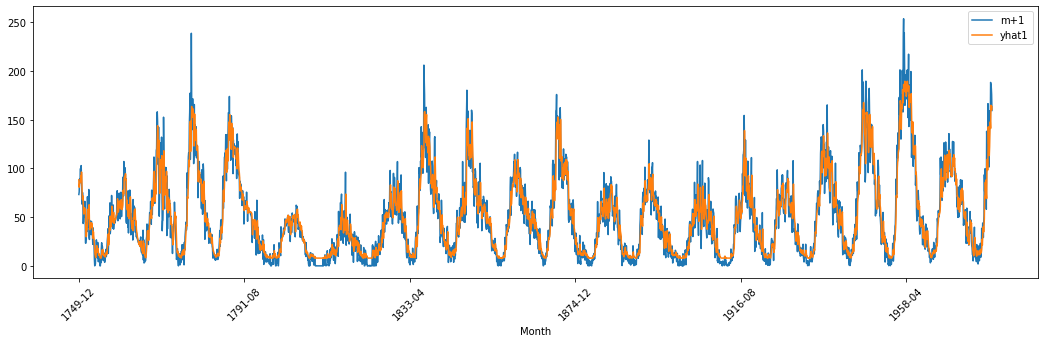

In [19]:
train[['m+1','yhat1']].plot(figsize=(18,5),rot=45)

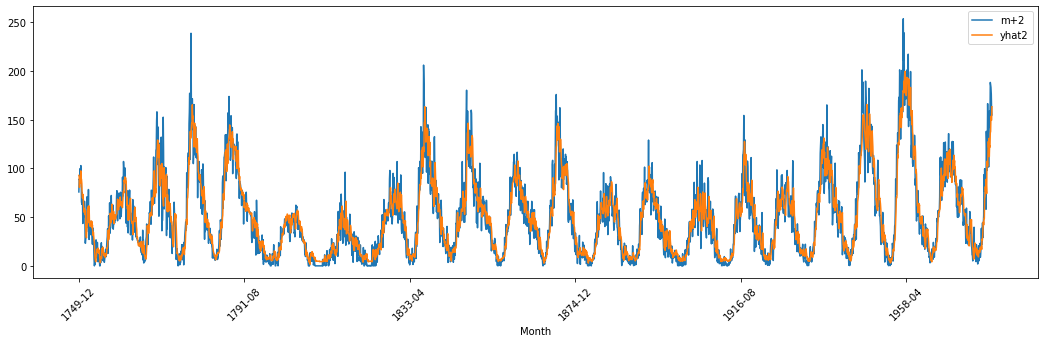

In [20]:
train[['m+2','yhat2']].plot(figsize=(18,5),rot=45)

In [25]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(train['m+1'],train['yhat1'])
mae = mean_absolute_error(train['m+1'],train['yhat1'])

In [26]:
print(mae)
print(mape)

10.976278917014879
946466506182156.8
